In [1]:
import logging
import os
import random
import pprint
import yaml
import numpy as np
import torch
from source.domain.experiment import get_data, make_objects, evaluate, train

# save weights and biases api key to .env file in project directory
assert os.getenv('WANDB_API_KEY')
assert torch.cuda.is_available()

# Ensure deterministic behavior
torch.backends.cudnn.deterministic = True
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)  # noqa: NPY002
torch.manual_seed(hash("by removing stochasticity") % 2**32 - 1)
torch.cuda.manual_seed_all(hash("so runs are repeatable") % 2**32 - 1)

logging.config.fileConfig(
    os.path.join(os.getcwd(), '/code/source/config/logging.conf'),
    # defaults={'logfilename': os.path.join(os.getcwd(), 'tests/test_files/log.log')},
    disable_existing_loggers=False,
)

/usr/local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config_file = '/code/source/entrypoints/run_fc_1.yaml'

In [3]:
with open(config_file) as f:
    config = yaml.safe_load(f)

pprint.pprint(config)

{'architecture': 'FC',
 'batch_size': 64,
 'epochs': 40,
 'layers': [500, 100],
 'learning_rate': 0.005,
 'notes': 'First run with a simple fully connected network',
 'num_reduce_learning_rate': 3,
 'optimizer': 'adam',
 'project': 'pytorch-demo-v2',
 'tags': ['pytorch', 'demo']}


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
logging.info(f"Device: {device}")

2023-12-31 19:32:45 - INFO     | Device: cuda:0


---

In [5]:
x_train, x_val, x_test, y_train, y_val, y_test = get_data(architecture=config['architecture'])
model, train_loader, validation_loader, criterion, optimizer_creator \
    = make_objects(
        x_train=x_train,
        x_val=x_val,
        y_train=y_train,
        y_val=y_val,
        architecture=config['architecture'],
        batch_size=config['batch_size'],
        kernels=config['kernels'] if 'kernels' in config else None,
        layers=config['layers'] if 'layers' in config else None,
        optimizer=config['optimizer'],
        device=device,
    )
print(model)

2023-12-31 19:32:50 - INFO     | Training set  : X-torch.Size([56000, 784]), y-torch.Size([56000])
2023-12-31 19:32:50 - INFO     | Validation set: X-torch.Size([7000, 784]), y-torch.Size([7000])
2023-12-31 19:32:50 - INFO     | Test set      : X-torch.Size([7000, 784]), y-torch.Size([7000])


FullyConnectedNN(
  (layers): ModuleList(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=500, bias=True)
    (2): ReLU()
    (3): Linear(in_features=500, out_features=100, bias=True)
    (4): ReLU()
    (5): Linear(in_features=100, out_features=10, bias=True)
  )
)


In [6]:
train(
    model=model,
    train_loader=train_loader,
    validation_loader=validation_loader,
    criterion=criterion,
    optimizer_creator=optimizer_creator,
    epochs=1, #,config['epochs'],
    learning_rate=config['learning_rate'],
    device=device,
    num_reduce_learning_rate=config['num_reduce_learning_rate'],
    log_wandb=False,
)

2023-12-31 19:32:50 - INFO     | Training on cuda:0; epochs: 1; learning rate: 0.005
  0%|          | 0/1 [00:00<?, ?it/s]2023-12-31 19:32:50 - INFO     | Epoch: 0 | Learning Rate: 0.005
2023-12-31 19:32:51 - INFO     | Epoch: 0 | Learning Rate: 0.005: Avg Training/Validation Loss after 64 examples: 10.041 | 124.564
2023-12-31 19:32:51 - INFO     | Epoch: 0 | Learning Rate: 0.005: Avg Training/Validation Loss after 1,920 examples: 12.678 | 0.878
2023-12-31 19:32:51 - INFO     | Epoch: 0 | Learning Rate: 0.005: Avg Training/Validation Loss after 3,776 examples: 0.810 | 0.628
2023-12-31 19:32:52 - INFO     | Epoch: 0 | Learning Rate: 0.005: Avg Training/Validation Loss after 5,632 examples: 0.571 | 0.470
2023-12-31 19:32:52 - INFO     | Epoch: 0 | Learning Rate: 0.005: Avg Training/Validation Loss after 7,488 examples: 0.479 | 0.487
2023-12-31 19:32:52 - INFO     | Epoch: 0 | Learning Rate: 0.005: Avg Training/Validation Loss after 9,344 examples: 0.454 | 0.410
2023-12-31 19:32:53 - INFO

2023-12-31 19:33:02 - INFO     | Final Average Loss on training set: 0.234
2023-12-31 19:33:02 - INFO     | Final Average Loss on validation set: 0.255
2023-12-31 19:33:02 - INFO     | Final Average Loss on test set: 0.282
2023-12-31 19:33:03 - INFO     | Weighted Precision: 0.926, Recall: 0.925, F1: 0.925
2023-12-31 19:33:03 - INFO     | Accuracy: 0.925


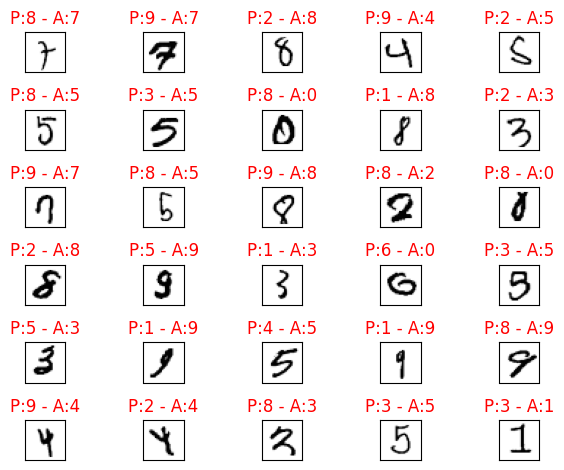

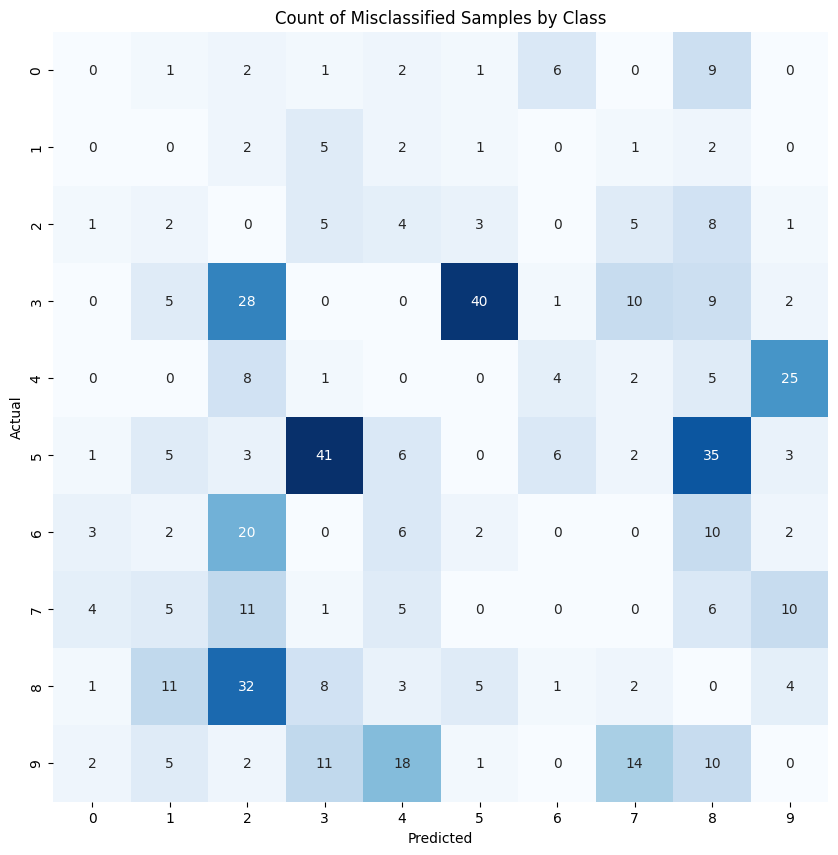

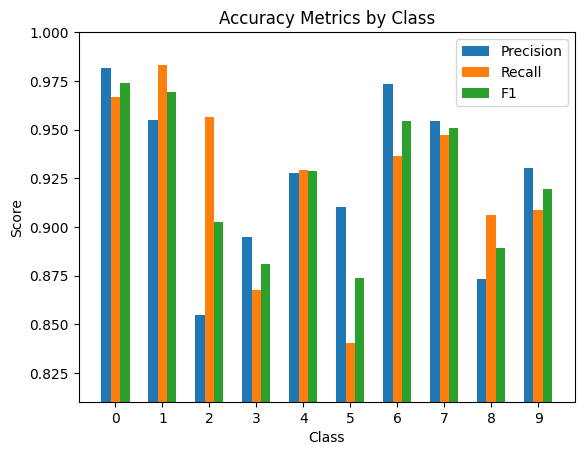

In [7]:
evaluate(
    model=model,
    train_loader=train_loader,
    validation_loader=validation_loader,
    x_test=x_test,
    y_test=y_test,
    criterion=criterion,
    device=device,
    log_wandb=False,
)